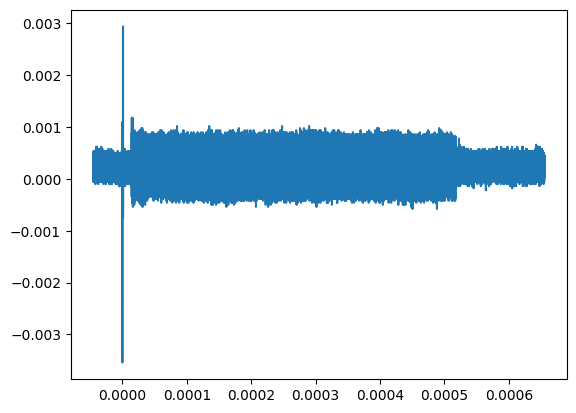

In [5]:
# Plotting a file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

i = 128

filename = f"data/SDS{i:05d}.dat"

# For example, if the .dat file is CSV-like
df = pd.read_csv(filename, delimiter=",", header=None)
d = df.to_numpy()
t = d[:, 0]
y = d[:, 2]
# mask = t > 1e-5
# plt.plot(t[mask], y[mask] ** 2)
plt.plot(d[:, 0], d[:, 2])
plt.show()

In [1]:
# # Plotting a file
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# for i in range(102, 184):
#     try:
#         filename = f"data/SDS{i:05d}.dat"
#         df = pd.read_csv(filename, delimiter=",", header=None)
#         d = df.to_numpy()
#         plt.plot(d[:, 0], d[:, 2])
#         plt.show()
#     except:
#         print(f"Problem with file {filename}")
#         continue

In [69]:
def compute_power_at_freq(t, v, freq_Hz, cutoff_freq):
    # Compute the power at f0 ± cutoff_freq using windowing
    f0 = freq_Hz
    fs = 1 / (t[1] - t[0])  # Sampling frequency

    # Apply Hann window
    window = np.hanning(len(v))
    v_windowed = v * window

    # Compute FFT
    n = len(v_windowed)
    fft_v = np.fft.fft(v_windowed)
    freqs = np.fft.fftfreq(n, 1 / fs)

    # Create a mask for frequencies within f0 ± cutoff_freq
    freq_mask = (freqs >= f0 - cutoff_freq) & (freqs <= f0 + cutoff_freq)

    # Compute power in the frequency band
    # Normalize by the sum of squared window values for correct scaling
    power = np.sum(np.abs(fft_v[freq_mask]) ** 2) / (np.sum(window**2) * fs)

    return power


def compute_power(file_num, tmin=1e-5, tmax=None, denoise=False, freq_Hz=None):
    filename = f"data/SDS{file_num:05d}.dat"
    try:
        df = pd.read_csv(filename, delimiter=",", header=None)
    except:
        print(f"Problem with file {filename}")
        return np.nan

    d = df.to_numpy()
    t = d[:, 0]
    v = d[:, 2]

    if tmax is None:
        tmax = max(t)

    t_mask = (t >= tmin) & (t <= tmax)
    t = t[t_mask]
    v = v[t_mask]

    if denoise:
        if freq_Hz is None:
            raise ValueError("Frequency must be provided if denoising")

        # pulse width is 1000 half-cycles
        ncycles = 500
        pulse_width_s = ncycles / freq_Hz
        cutoff_freq = 2 / pulse_width_s

        # restrict to pulse width data
        t_mask = t <= tmin + pulse_width_s
        t = t[t_mask]
        v = v[t_mask]

        power = compute_power_at_freq(t, v, freq_Hz, cutoff_freq)

    else:
        power = np.linalg.norm(v) ** 2
    # power = np.max(v)**2
    return power

In [70]:
compute_power(109)

ValueError: Frequency must be provided if denoising

In [79]:
# Read the metadata.csv file
metadata = pd.read_csv("metadata.csv")

# Display the first few rows of the metadata
# print(metadata.head())

# You can now use this metadata DataFrame for further analysis or processing
metadata.columns

Index(['Position', 'Row', 'Column', 'Frequency (MHz)', 'SDS Sample #',
       'Pulse width', 'Ignore', 'Notes'],
      dtype='object')

In [80]:
# Function to check if a string can be converted to an integer
def is_integer(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

In [92]:
# Create a function to get power for a specific position and skull state
def get_power_for_position(col, row, freq, skull_position):
    row_data = metadata[
        (metadata["Column"] == col)
        & (metadata["Row"] == row)
        & (metadata["Position"] == skull_position)
        & (metadata["Frequency (MHz)"] == freq)
    ]

    if row_data.empty:
        return np.nan

    file_num = row_data["SDS Sample #"].values[0]
    if pd.isna(file_num) or not is_integer(file_num):
        return np.nan
    return compute_power(int(file_num), freq_Hz=freq * 1e6)


# drop rows with Ignore == True
metadata = metadata[metadata["Ignore"] != 1]

# Get unique positions
positions = metadata[["Column", "Row", "Frequency (MHz)"]].drop_duplicates()

# Create a list to store results
results = []

# Iterate through positions
for _, position in positions.iterrows():

    col, row, freq = (
        position["Column"],
        position["Row"],
        position["Frequency (MHz)"],
    )

    # Get power for skull position 0 and 1
    power_no_skull = get_power_for_position(col, row, freq, "Water")
    power_skull1 = get_power_for_position(col, row, freq, "Skull Position 1")
    power_skull2 = get_power_for_position(col, row, freq, "Skull Position 2")

    # Check if the position exists for both skull positions
    if np.isnan(power_no_skull) and np.isnan(power_skull1) and np.isnan(power_skull2):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for either skull position."
        )
    elif np.isnan(power_no_skull):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for skull position 0."
        )
    elif np.isnan(power_skull1) and np.isnan(power_skull2):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for skull position 1."
        )
    else:
        results.append(
            {
                "Column": col,
                "Row": row,
                "Power (No Skull)": power_no_skull,
                "Power (Skull 1)": power_skull1,
                "Power (Skull 2)": power_skull2,
                "Frequency (MHz)": freq,
                "Attenuation_1 (dB)": 10 * np.log10(power_no_skull / power_skull1),
                "Attenuation_2 (dB)": 10 * np.log10(power_no_skull / power_skull2),
            }
        )

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Display the table
print(result_df.to_string(index=False))

# Optionally, you can save this to a CSV file
# result_df.to_csv('power_comparison.csv', index=False)

 Column  Row  Power (No Skull)  Power (Skull 1)  Power (Skull 2)  Frequency (MHz)  Attenuation_1 (dB)  Attenuation_2 (dB)
      2    3      1.821400e-10     2.586172e-11     1.262813e-11                1            8.477480           11.590663
      2    3      9.591147e-15     7.681409e-16     7.394266e-16                2           10.964297           11.129755
      2    3      1.156058e-14     2.978350e-15     3.711592e-16                3            5.890039           14.934193
      2    3      6.255382e-15     3.528147e-16     6.673288e-17                4           12.487071           19.719139
      2    4      3.622223e-11     1.020641e-10     1.989924e-11                1           -4.498977            2.601386
      2    4      5.777631e-15     1.214445e-15     3.372609e-16                2            6.773718           12.337838
      2    4      1.112346e-14     3.567457e-15     1.837955e-16                3            4.938813           17.819051
      2    4      3.8447

In [93]:
result_df

,Column,Row,Power (No Skull),Power (Skull 1),Power (Skull 2),Frequency (MHz),Attenuation_1 (dB),Attenuation_2 (dB)
0,2,3,1.821400e-10,2.586172e-11,1.262813e-11,1,8.477480,11.590663
1,2,3,9.591147e-15,7.681409e-16,7.394266e-16,2,10.964297,11.129755
2,2,3,1.156058e-14,2.978350e-15,3.711592e-16,3,5.890039,14.934193
3,2,3,6.255382e-15,3.528147e-16,6.673288e-17,4,12.487071,19.719139
4,2,4,3.622223e-11,1.020641e-10,1.989924e-11,1,-4.498977,2.601386
5,2,4,5.777631e-15,1.214445e-15,3.372609e-16,2,6.773718,12.337838
6,2,4,1.112346e-14,3.567457e-15,1.837955e-16,3,4.938813,17.819051
7,2,4,3.844726e-15,4.541322e-15,1.973235e-16,4,-0.723169,12.896865
8,2,5,5.575819e-12,2.374569e-11,2.819039e-12,1,-6.292760,2.962076
9,2,5,2.001481e-15,3.332638e-15,3.768810e-16,2,-2.214366,7.251472


In [94]:
# # Filter the result_df to keep only specific (column, row) combinations
# filtered_positions = [(2,2), (2,3), (3,2), (3,3)]
# result_df_filtered = result_df[result_df.apply(lambda row: (row['Column'], row['Row']) in filtered_positions, axis=1)]

# # Display the filtered DataFrame
# print(result_df_filtered.to_string(index=False))

# Filter out entries with row = 5
result_df = result_df[result_df["Row"] != 5]

# Display the updated DataFrame
print(result_df.to_string(index=False))

# Optionally, you can save this to a CSV file
# result_df.to_csv('power_comparison_filtered.csv', index=False)

 Column  Row  Power (No Skull)  Power (Skull 1)  Power (Skull 2)  Frequency (MHz)  Attenuation_1 (dB)  Attenuation_2 (dB)
      2    3      1.821400e-10     2.586172e-11     1.262813e-11                1            8.477480           11.590663
      2    3      9.591147e-15     7.681409e-16     7.394266e-16                2           10.964297           11.129755
      2    3      1.156058e-14     2.978350e-15     3.711592e-16                3            5.890039           14.934193
      2    3      6.255382e-15     3.528147e-16     6.673288e-17                4           12.487071           19.719139
      2    4      3.622223e-11     1.020641e-10     1.989924e-11                1           -4.498977            2.601386
      2    4      5.777631e-15     1.214445e-15     3.372609e-16                2            6.773718           12.337838
      2    4      1.112346e-14     3.567457e-15     1.837955e-16                3            4.938813           17.819051
      2    4      3.8447

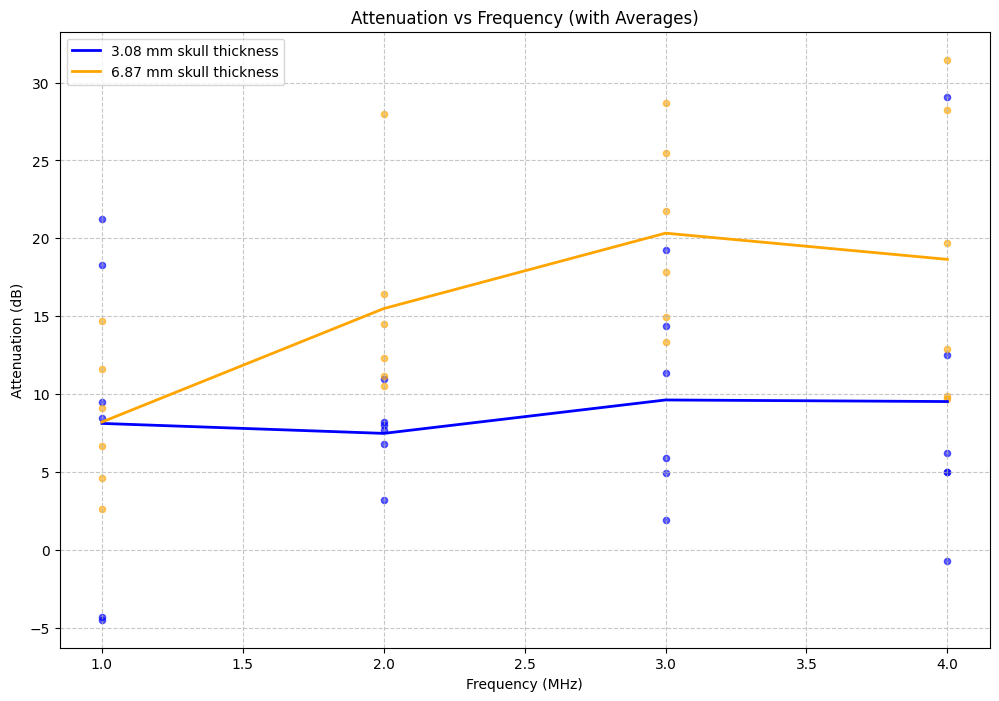

In [100]:
# Create a scatter plot of Attenuation vs Frequency for both Attenuation_1 and Attenuation_2
plt.figure(figsize=(12, 8))

# Plot Attenuation_1
plt.scatter(
    result_df["Frequency (MHz)"],
    result_df["Attenuation_1 (dB)"],
    alpha=0.6,
    color="blue",
    s=20,  # Reduced spot size
)

# Plot Attenuation_2
plt.scatter(
    result_df["Frequency (MHz)"],
    result_df["Attenuation_2 (dB)"],
    alpha=0.6,
    color="orange",
    s=20,  # Reduced spot size
)

# Calculate and plot average attenuation for each frequency
avg_attenuation_1 = result_df.groupby("Frequency (MHz)")["Attenuation_1 (dB)"].mean()
avg_attenuation_2 = result_df.groupby("Frequency (MHz)")["Attenuation_2 (dB)"].mean()

plt.plot(
    avg_attenuation_1.index,
    avg_attenuation_1.values,
    label="3.08 mm skull thickness",
    linewidth=2,
    markersize=8,
    color="blue",
)

plt.plot(
    avg_attenuation_2.index,
    avg_attenuation_2.values,
    label="6.87 mm skull thickness",
    linewidth=2,
    markersize=8,
    color="orange",
)

# Set labels and title
plt.xlabel("Frequency (MHz)")
plt.ylabel("Attenuation (dB)")
plt.title("Attenuation vs Frequency (with Averages)")

# Add a grid for better readability
plt.grid(True, linestyle="--", alpha=0.7)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [91]:
avg_attenuation

Frequency (MHz)
1     8.198158
2    15.485166
3    20.328550
4    18.644926
Name: Attenuation (dB), dtype: float64